<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with Self-Playing Deep Reinforcement Learning


## Initializing the game

In [1]:
#@title Required installation
# !pip install -q black gymnasium pettingzoo==1.22.3 tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 5.0 MB/s eta 0:00:00
Cloning into 'HomMul'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 115 (delta 38), reused 53 (delta 16), pack-reused 0
Receiving objects: 100% (115/115), 4.84 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
#@title Change working path
%cd HomMul/

/content/HomMul


In [3]:
#@title Import libraries and modules
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [4]:
#@title Setup Gymnasium environment
env = HomMul(include_all_states=True)
original_env = HomMul(include_all_states=True, render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#@title Example of gameplay
episodes = 2

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 3
--Current life of agent 1: 4
--Current life of agent 2: 4
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4

--Action taken by player 1: play
--Action taken by player 2: wait

--Days left: 2
--Current life of agent 1: 2
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: play
--Previous action of agent 2: wait

--Action taken by player 1: wait
--Action taken by player 2: play

--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 1
--Probability of payoff for agent 1: 0.4
--Probability of payoff for agent 2: 0.4
--Previous action of agent 1: wait
--Previous action of agent 2: play

--Action taken by player 1: play
--Action taken by player 2: play

--Days left: 0
--Current life of agent 1: 2
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agen

## Heuristics Benchmarking


death rate (in %) of player1: 37.5 +- 5.033
death rate (in %) of player2: 37.5 +- 5.033


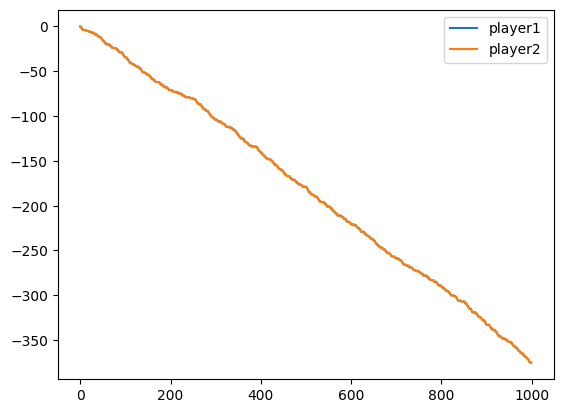

In [6]:
#@title Case - both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)

interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 62.2 +- 3.784
death rate (in %) of player2: 62.2 +- 3.784


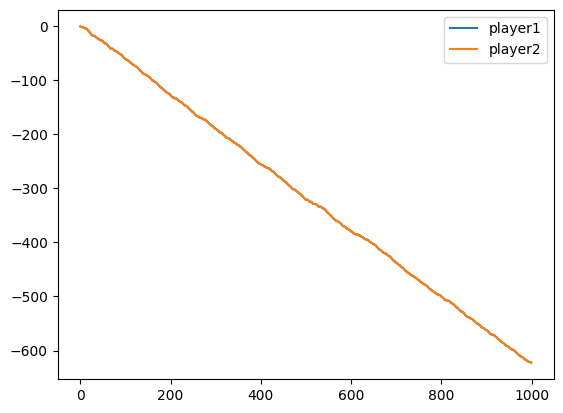

In [7]:
#@title Case - both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 61.6 +- 4.400
death rate (in %) of player2: 69.2 +- 4.570


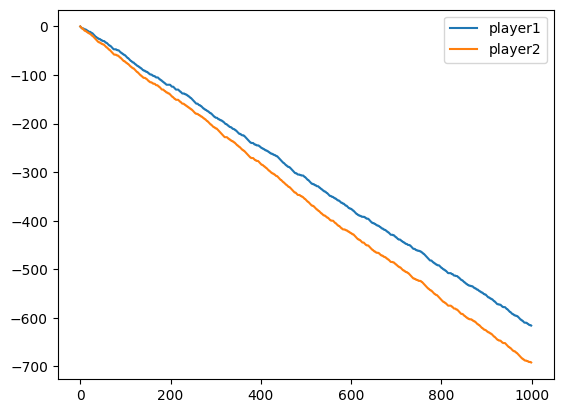

In [8]:
#@title Case - player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 69.2 +- 8.176
death rate (in %) of player2: 60.8 +- 7.709


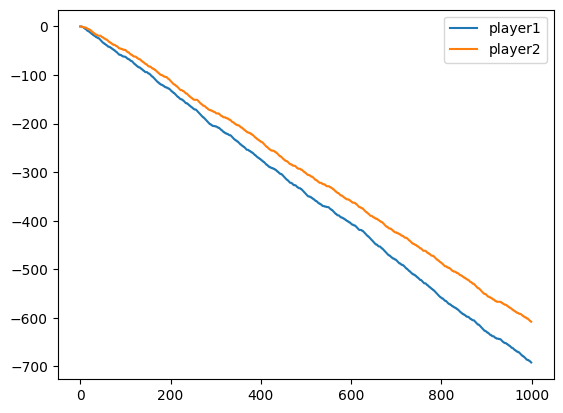

In [9]:
#@title Case - player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 56.9 +- 7.601
death rate (in %) of player2: 49.1 +- 7.485


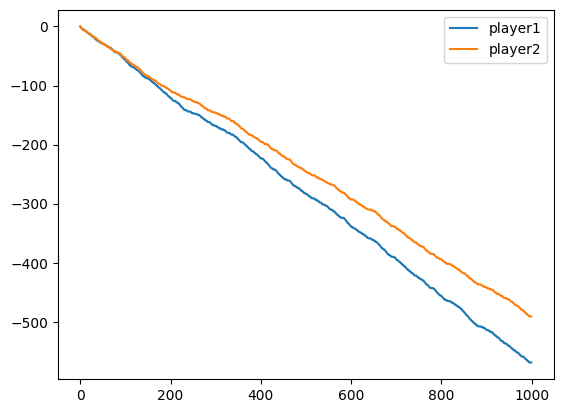

In [10]:
#@title Case - Always play vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 61.5 +- 4.332
death rate (in %) of player2: 63.9 +- 6.471


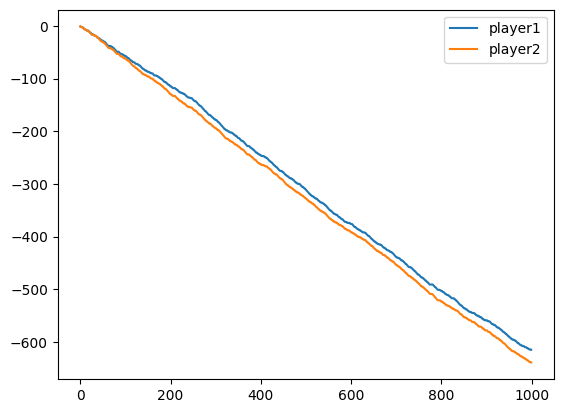

In [11]:
#@title Case - Always wait vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 68.8 +- 8.975
death rate (in %) of player2: 48.7 +- 7.674


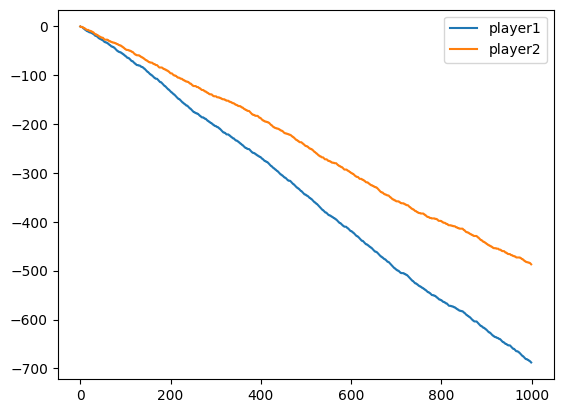

In [12]:
#@title Case - Always play vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate (in %) of player1: 64.0 +- 7.832
death rate (in %) of player2: 54.2 +- 7.992


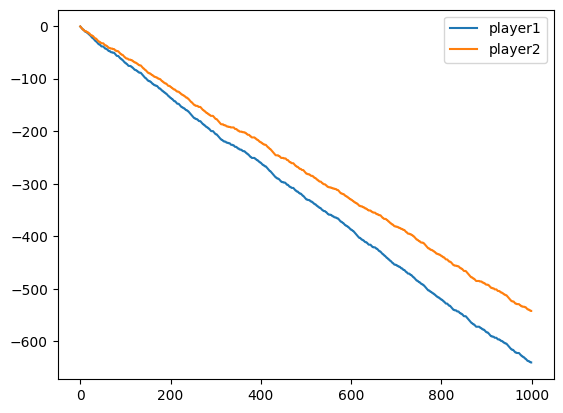

In [13]:
#@title Case - Always wait vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
interval_size = 100
num_intervals = episodes // interval_size

means = []
std_devs = []

for i in range(0, episodes, interval_size):
    interval_data = arr[i:i+interval_size]
    mean = np.mean(interval_data, axis=0)
    means.append(mean)

for i in range(num_intervals - 1):
    mean_diff = means[i+1] - means[i]
    std_devs.append(mean_diff)

avg = (np.mean(arr, axis=0)) * -100
std_dev = np.std(std_devs, axis=0) * 100

print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [14]:
#@title Load optimal policy

# def optimal(obs):
#     df = pd.read_csv("models/optimal_policy.csv")
#     return df.loc[
#         (df["days_left"] == obs["player1"]["observation"][0][0]) &
#         (df["player1_life_points"] == obs["player1"]["observation"][0][1]) &
#         (df["player2_life_points"] == obs["player1"]["observation"][0][2]) &
#         (df["player1_prob_payoff"] == obs["player1"]["observation"][0][3])
#     ]["action"].values[0] - 1

In [15]:
#@title Visualize optimal policy

# df = pd.read_csv("models/optimal_policy.csv")

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# arr = df.loc[(df["days_left"] == 1) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

# ax1.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax1.set_title("Day->1 Env->Bad")
# ax1.set_xticks([0, 1, 2], [1, 2, 3])
# ax1.set_yticks([0, 1, 2], [1, 2, 3])

# arr = df.loc[(df["days_left"] == 2) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] < 0.3), "action"].values

# ax2.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax2.set_title("Day->2 Env->Bad")
# ax2.set_xticks([0, 1, 2], [1, 2, 3])
# ax2.set_yticks([0, 1, 2], [1, 2, 3])

# arr = df.loc[(df["days_left"] == 1) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

# ax3.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax3.set_title("Day->1 Env->Good")
# ax3.set_xticks([0, 1, 2], [1, 2, 3])
# ax3.set_yticks([0, 1, 2], [1, 2, 3])

# arr = df.loc[(df["days_left"] == 2) & 
#     (df["player1_life_points"] > 0.5) & 
#     (df["player2_life_points"] > 0.5) & (df["player1_prob_payoff"] > 0.3), "action"].values

# ax = ax4.imshow(np.reshape(arr, (3, 3)), cmap='bwr')
# ax4.set_title("Day->2 Env->Good")
# ax4.set_xticks([0, 1, 2], [1, 2, 3])
# ax4.set_yticks([0, 1, 2], [1, 2, 3])
# ax4.set_xlabel("player2_life_points")
# ax4.set_ylabel("player1_life_points")

# red_patch = mpatches.Patch(color='red', label='Play')
# blue_patch = mpatches.Patch(color='blue', label='Wait')

# plt.legend(handles=[red_patch, blue_patch])

# fig.tight_layout()
# plt.show()

In [16]:
#@title Case - optimal vs Always wait
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs),
#             "player2": 0
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

In [17]:
#@title Case - optimal vs Always play
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs), 
#             "player2": 0
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

In [18]:
#@title Case - optimal vs hail mary
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs),
#             "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

In [19]:
#@title Case - optimal vs optimal
# episodes = 1000

# episode_rews = []

# for _ in range(episodes):

#     obs = env.reset()
#     while env.agents:
#         acts = {
#             "player1": optimal(obs),
#             "player2": optimal(obs)
#         }

#         obs, rews, terms, truncs, infos = env.step(acts)
#         # print(obs, rews)

#     episode_rews.append([rews['player1'], rews['player2']])

# arr = np.array(episode_rews)
# interval_size = 100
# num_intervals = episodes // interval_size

# means = []
# std_devs = []

# for i in range(0, episodes, interval_size):
#     interval_data = arr[i:i+interval_size]
#     mean = np.mean(interval_data, axis=0)
#     means.append(mean)

# for i in range(num_intervals - 1):
#     mean_diff = means[i+1] - means[i]
#     std_devs.append(mean_diff)

# avg = (np.mean(arr, axis=0)) * -100
# std_dev = np.std(std_devs, axis=0) * 100

# print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
# print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
# plt.plot(arr.cumsum(axis=0))
# plt.legend(("player1", "player2"))
# plt.show()

## Deep RL training


In [20]:
#@title Define heuristic algos in Tianshou
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 2] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## optimal agent 
class OptimalPolicy(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        df = pd.read_csv("models/optimal_policy.csv")

        for i in range(mask.shape[0]):
            action = df.loc[
                (df["days_left"] == obs[i, :, 0][0]) &
                (df["player1_life_points"] == obs[i, :, 1][0]) &
                (df["player2_life_points"] == obs[i, :, 2][0]) &
                (df["player1_prob_payoff"] == obs[i, :, 3][0])
            ]["action"].values[0] - 1
            if action:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [24]:
#@title Prerequisites for training
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env_train():
    env = HomMul(include_all_states=True)
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

def _get_env_test():
    env = HomMul(include_all_states=True)
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env_train()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        # device="cuda",
    )#.to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    if pretrained:
        model_save_path = os.path.join("models", "vs_hail_mary.pth")
        model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent(pretrained=False)
agent_learn2 = _get_agent(pretrained=False)

train_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_train())

train_envs = DummyVectorEnv([_get_env_train for _ in range(10)])
test_envs = DummyVectorEnv([_get_env_test for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    train_policies,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)

test_policies = MultiAgentPolicyManager([agent_learn1, agent_learn2],  _get_env_test())
test_collector = Collector(test_policies, test_envs, exploration_noise=True)

train_collector.collect(n_episode=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        torch.save(train_policies.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        torch.save(train_policies.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= -0.05

def train_fn(epoch, env_step):
    # freeze training for player1
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].set_eps(0.05)

    if not hasattr(train_policies.policies[agents[1]], 'nolearn'):
        train_policies.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [25]:
#@title Clear logs and setup TensorBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Evolution 1


Epoch #1: 1001it [00:02, 401.76it/s, env_step=1000, len=6, n/ep=7, n/st=50, player1/loss=0.118, player2/loss=0.280, rew=-0.43]                          


Epoch #1: test_reward: -0.560000 ± 0.496387, best_reward: -0.560000 ± 0.496387 in #1


Epoch #2: 1001it [00:01, 658.39it/s, env_step=2000, len=8, n/ep=8, n/st=50, player1/loss=0.099, player2/loss=0.187, rew=-0.75]                          


Epoch #2: test_reward: -0.580000 ± 0.493559, best_reward: -0.560000 ± 0.496387 in #1


Epoch #3: 1001it [00:01, 557.55it/s, env_step=3000, len=7, n/ep=10, n/st=50, player1/loss=0.089, player2/loss=0.177, rew=-0.70]                          


Epoch #3: test_reward: -0.550000 ± 0.497494, best_reward: -0.550000 ± 0.497494 in #3


Epoch #4: 1001it [00:01, 790.44it/s, env_step=4000, len=8, n/ep=12, n/st=50, player1/loss=0.078, player2/loss=0.189, rew=-0.58]                          


Epoch #4: test_reward: -0.550000 ± 0.497494, best_reward: -0.550000 ± 0.497494 in #3


Epoch #5: 1001it [00:01, 808.26it/s, env_step=5000, len=6, n/ep=7, n/st=50, player1/loss=0.094, player2/loss=0.183, rew=-0.57]                          


Epoch #5: test_reward: -0.450000 ± 0.497494, best_reward: -0.450000 ± 0.497494 in #5


Epoch #6: 1001it [00:01, 875.13it/s, env_step=6000, len=9, n/ep=7, n/st=50, player1/loss=0.099, player2/loss=0.198, rew=-0.71]                          


Epoch #6: test_reward: -0.510000 ± 0.499900, best_reward: -0.450000 ± 0.497494 in #5


Epoch #7: 1001it [00:01, 829.53it/s, env_step=7000, len=7, n/ep=10, n/st=50, player1/loss=0.099, player2/loss=0.220, rew=-0.60]                          


Epoch #7: test_reward: -0.440000 ± 0.496387, best_reward: -0.440000 ± 0.496387 in #7


Epoch #8: 1001it [00:01, 858.41it/s, env_step=8000, len=7, n/ep=10, n/st=50, player1/loss=0.112, player2/loss=0.215, rew=-0.60]                          


Epoch #8: test_reward: -0.520000 ± 0.499600, best_reward: -0.440000 ± 0.496387 in #7


Epoch #9: 1001it [00:01, 691.22it/s, env_step=9000, len=8, n/ep=4, n/st=50, player1/loss=0.121, player2/loss=0.234, rew=-0.75]                          


Epoch #9: test_reward: -0.580000 ± 0.493559, best_reward: -0.440000 ± 0.496387 in #7


Epoch #10: 1001it [00:01, 526.39it/s, env_step=10000, len=6, n/ep=5, n/st=50, player1/loss=0.118, player2/loss=0.243, rew=-0.60]                          


Epoch #10: test_reward: -0.470000 ± 0.499099, best_reward: -0.440000 ± 0.496387 in #7


Epoch #11: 1001it [00:01, 818.49it/s, env_step=11000, len=7, n/ep=10, n/st=50, player1/loss=0.127, player2/loss=0.267, rew=-0.40]                          


Epoch #11: test_reward: -0.460000 ± 0.498397, best_reward: -0.440000 ± 0.496387 in #7


Epoch #12: 1001it [00:01, 755.26it/s, env_step=12000, len=6, n/ep=8, n/st=50, player1/loss=0.145, player2/loss=0.277, rew=-0.62]                          


Epoch #12: test_reward: -0.600000 ± 0.489898, best_reward: -0.440000 ± 0.496387 in #7


Epoch #13: 1001it [00:01, 775.26it/s, env_step=13000, len=9, n/ep=10, n/st=50, player1/loss=0.148, player2/loss=0.264, rew=-0.60]                          


Epoch #13: test_reward: -0.490000 ± 0.499900, best_reward: -0.440000 ± 0.496387 in #7


Epoch #14: 1001it [00:01, 800.61it/s, env_step=14000, len=8, n/ep=9, n/st=50, player1/loss=0.164, player2/loss=0.297, rew=-0.67]                          


Epoch #14: test_reward: -0.510000 ± 0.499900, best_reward: -0.440000 ± 0.496387 in #7


Epoch #15: 1001it [00:01, 834.94it/s, env_step=15000, len=7, n/ep=9, n/st=50, player1/loss=0.155, player2/loss=0.304, rew=-0.44]                          


Epoch #15: test_reward: -0.580000 ± 0.493559, best_reward: -0.440000 ± 0.496387 in #7


Epoch #16: 1001it [00:01, 639.51it/s, env_step=16000, len=7, n/ep=8, n/st=50, player1/loss=0.177, player2/loss=0.295, rew=-0.62]                          


Epoch #16: test_reward: -0.410000 ± 0.491833, best_reward: -0.410000 ± 0.491833 in #16


Epoch #17: 1001it [00:01, 623.68it/s, env_step=17000, len=7, n/ep=8, n/st=50, player1/loss=0.168, player2/loss=0.319, rew=-0.62]                          


Epoch #17: test_reward: -0.490000 ± 0.499900, best_reward: -0.410000 ± 0.491833 in #16


Epoch #18: 1001it [00:01, 780.66it/s, env_step=18000, len=8, n/ep=7, n/st=50, player1/loss=0.194, player2/loss=0.327, rew=-0.57]                          


Epoch #18: test_reward: -0.450000 ± 0.497494, best_reward: -0.410000 ± 0.491833 in #16


Epoch #19: 1001it [00:01, 771.87it/s, env_step=19000, len=9, n/ep=7, n/st=50, player1/loss=0.199, player2/loss=0.346, rew=-0.71]                          


Epoch #19: test_reward: -0.580000 ± 0.493559, best_reward: -0.410000 ± 0.491833 in #16


Epoch #20: 1001it [00:01, 783.11it/s, env_step=20000, len=6, n/ep=10, n/st=50, player1/loss=0.197, player2/loss=0.349, rew=-0.50]                          


Epoch #20: test_reward: -0.480000 ± 0.499600, best_reward: -0.410000 ± 0.491833 in #16
##########

death rate (in %) of player1: 31.6 +- 4.040
death rate (in %) of player2: 31.8 +- 3.843


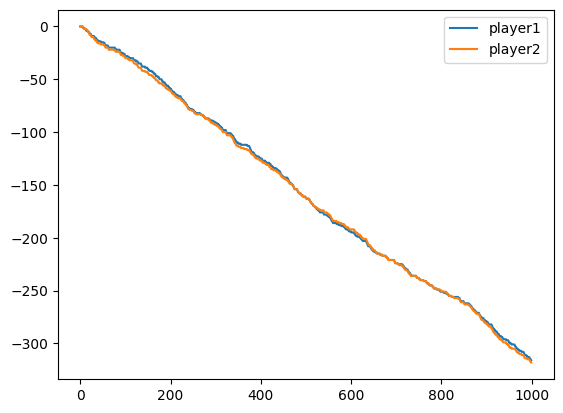

In [26]:
#@title Training
for evolution in range(1):
    print(f"#### Evolution {evolution+1}")
    result = offpolicy_trainer(
        policy=train_policies,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=20,
        step_per_epoch=1000,
        step_per_collect=50,
        episode_per_test=100,
        batch_size=64,
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=0.1,
        test_in_train=False,
        reward_metric=reward_metric,
        logger=logger
    )

    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    if not hasattr(train_policies.policies[agents[0]], 'nolearn'):
        train_policies.policies[agents[0]].load_state_dict(torch.load(model_save_path2))
        train_policies.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

    result = test_collector.collect(n_episode=1000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    print("#"*10)
    print()
    print(f"death rate (in %) of player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")
    plt.plot(arr.cumsum(axis=0))
    plt.legend(("player1", "player2"))
    plt.show()

    print()

In [25]:
#@title Save Policy as CSV

df = []
obs = []

for days_left in range(1, env.num_days):
    for player1_life_points in range(1, env.num_life_points):
        for player2_life_points in range(1, env.num_life_points):
            for payoff in [0.2, 0.4]:
                curr_obs = [
                    days_left, 
                    player1_life_points, 
                    player2_life_points, 
                    payoff,
                    payoff
                ]
                obs.append({
                    'agent_id': 'player2',
                    'obs': np.array([curr_obs], dtype='float32'),
                    'mask': [True, True, False]
                })
                df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff"
]
df = pd.DataFrame(df, columns=cols)

scaler = MinMaxScaler(feature_range=(0, 1))

df["player2_predicted_action"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = train_policies.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]
df["player2_logit_diff"] = scaler.fit_transform((df["player2_logit_play"] - df["player2_logit_wait"]).values[:, None])

df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player2_predicted_action,player2_logit_wait,player2_logit_play,player2_logit_diff
0,1,1,1,0.2,0.2,play,-13.306664,-13.222314,0.635688
1,1,1,1,0.4,0.4,play,-13.752058,-13.681378,0.629523
2,1,1,2,0.2,0.2,wait,-12.925547,-12.965901,0.579447
3,1,1,2,0.4,0.4,wait,-13.200659,-13.291486,0.556685
4,1,1,3,0.2,0.2,wait,-12.828230,-12.892140,0.568824


In [26]:
#@title Visualize policy (mean gameplay)
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5859375

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


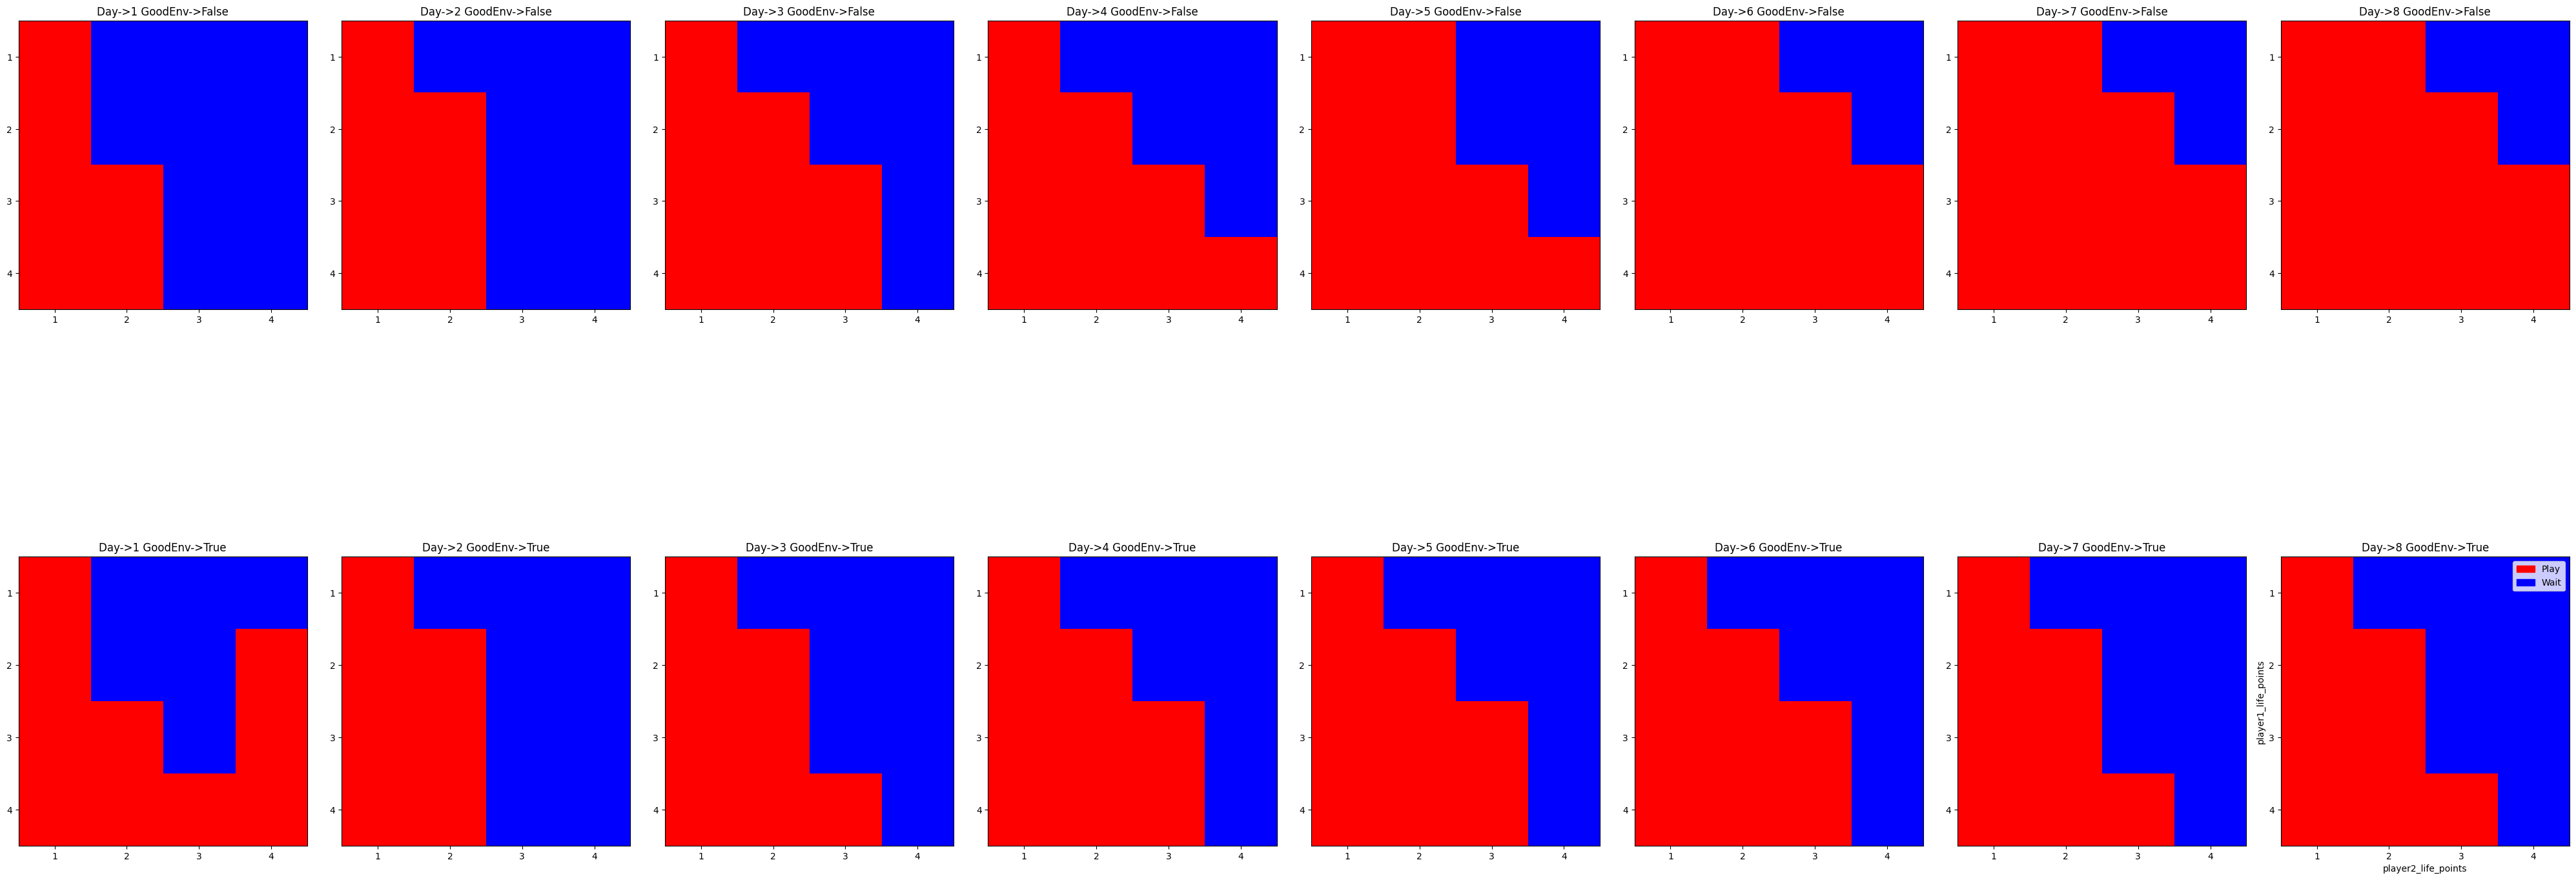

In [28]:
#@title Visualize policy
##TODO display logits instead
fig, axes = plt.subplots(2, 8, figsize=(40, 20))

def _get_im(ax, days_left, is_env_good):
    if is_env_good:
        prob_succ = 0.2
    else:
        prob_succ = 0.4

    arr = df.loc[
        (df["days_left"] == days_left) & 
        (df["player1_prob_payoff"] == prob_succ), 
        "player2_predicted_action"
    ].map({"wait": 0, "play": 1}).values

    ax.imshow(np.reshape(arr, (4, 4)), cmap='bwr')
    ax.set_title(f"Day->{days_left} GoodEnv->{is_env_good}")
    ax.set_xticks(np.arange(0, 4, 1), np.arange(1, 5, 1))
    ax.set_yticks(np.arange(0, 4, 1), np.arange(1, 5, 1))

for idx, ax in enumerate(np.ravel(axes)):
    if idx < 8:
        is_env_good=False
    else:
        is_env_good=True
    days_left = idx%8 + 1
    
    _get_im(ax, days_left=days_left, is_env_good=is_env_good)

ax.set_xlabel("player2_life_points")
ax.set_ylabel("player1_life_points")

red_patch = mpatches.Patch(color='red', label='Play')
blue_patch = mpatches.Patch(color='blue', label='Wait')

plt.legend(handles=[red_patch, blue_patch])

fig.tight_layout()
plt.show()

In [60]:
from itertools import product

algos = [AlwaysPlay(), AlwaysWait(), HailMary(), RandomAgent(), agent_learn2]
df = []

for algo1, algo2 in product(algos, repeat=2):
    test_policies = MultiAgentPolicyManager([algo1, algo2],  _get_env_test())
    test_collector = Collector(test_policies, test_envs, exploration_noise=True)
    result = test_collector.collect(n_episode=1000)
    arr = result["rews"]
    interval_size = 100
    num_intervals = episodes // interval_size

    means = []
    std_devs = []

    for i in range(0, episodes, interval_size):
        interval_data = arr[i:i+interval_size]
        mean = np.mean(interval_data, axis=0)
        means.append(mean)

    for i in range(num_intervals - 1):
        mean_diff = means[i+1] - means[i]
        std_devs.append(mean_diff)

    avg = (np.mean(arr, axis=0)) * -100
    std_dev = np.std(std_devs, axis=0) * 100

    df.append([str(algo1).split('(')[0], str(algo2).split('(')[0], avg[0], std_dev[0], avg[1], std_dev[1]])

    print("#"*10)
    print()
    print(f"death rate (in %) of {str(algo1).split('(')[0]} as player1: {avg[0]:.1f} +- {std_dev[0]:.3f}")
    print(f"death rate (in %) of {str(algo2).split('(')[0]} as player2: {avg[1]:.1f} +- {std_dev[1]:.3f}")

    print()

##########

death rate (in %) of AlwaysPlay as player1: 36.7 +- 2.973
death rate (in %) of AlwaysPlay as player2: 36.7 +- 2.973

##########

death rate (in %) of AlwaysPlay as player1: 71.3 +- 8.829
death rate (in %) of AlwaysWait as player2: 63.6 +- 7.490

##########

death rate (in %) of AlwaysPlay as player1: 67.8 +- 6.880
death rate (in %) of HailMary as player2: 47.4 +- 5.573

##########

death rate (in %) of AlwaysPlay as player1: 56.5 +- 4.989
death rate (in %) of RandomAgent as player2: 48.9 +- 4.190

##########

death rate (in %) of AlwaysPlay as player1: 66.0 +- 3.071
death rate (in %) of DQNPolicy as player2: 47.0 +- 6.600

##########

death rate (in %) of AlwaysWait as player1: 63.7 +- 5.266
death rate (in %) of AlwaysPlay as player2: 71.9 +- 4.725

##########

death rate (in %) of AlwaysWait as player1: 62.2 +- 8.176
death rate (in %) of AlwaysWait as player2: 62.2 +- 8.176

##########

death rate (in %) of AlwaysWait as player1: 62.2 +- 4.055
death rate (in %) of HailMary

In [61]:
df = pd.DataFrame(df, columns=["player1_name", "player2_name", "player1_mean_death_rate", "player1_std_dev_death_rate", "player2_mean_death_rate", "player2_std_dev_death_rate"])
df.head()

,player1_name,player2_name,player1_mean_death_rate,player1_std_dev_death_rate,player2_mean_death_rate,player2_std_dev_death_rate
0,AlwaysPlay,AlwaysPlay,36.7,2.973131,36.7,2.973131
1,AlwaysPlay,AlwaysWait,71.3,8.828965,63.6,7.489911
2,AlwaysPlay,HailMary,67.8,6.879922,47.4,5.573305
3,AlwaysPlay,RandomAgent,56.5,4.988877,48.9,4.189935
4,AlwaysPlay,DQNPolicy,66.0,3.071172,47.0,6.599663


In [118]:
for idx, group in df.groupby("player1_name"):
    group = group.loc[~(group.player1_name == group.player2_name)]
    wins = (group.player1_mean_death_rate < group.player2_mean_death_rate).sum()
    print(idx, wins)

AlwaysPlay 0
AlwaysWait 2
DQNPolicy 4
HailMary 3
RandomAgent 1


In [105]:
arr = [str(tuple(np.around(x, 2))) for x in df[["player1_mean_death_rate", "player2_mean_death_rate"]].values]
arr = np.reshape(arr, (5, 5))
arr

pd.DataFrame(arr, columns=df.player1_name.unique(), index=df.player1_name.unique())

,AlwaysPlay,AlwaysWait,HailMary,RandomAgent,DQNPolicy
AlwaysPlay,"(36.7, 36.7)","(71.3, 63.6)","(67.8, 47.4)","(56.5, 48.9)","(66.0, 47.0)"
AlwaysWait,"(63.7, 71.9)","(62.2, 62.2)","(62.2, 52.1)","(63.2, 63.6)","(62.8, 51.1)"
HailMary,"(60.5, 70.6)","(56.9, 63.9)","(36.2, 36.2)","(59.8, 63.2)","(57.8, 52.2)"
RandomAgent,"(47.4, 56.0)","(65.5, 63.6)","(62.2, 50.5)","(55.9, 56.2)","(61.8, 49.4)"
DQNPolicy,"(34.1, 61.4)","(53.0, 63.9)","(49.9, 54.3)","(46.0, 60.2)","(33.4, 35.1)"
